In [1]:
import networkx as nx
import osmnx as ox
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import geopandas as gpd


In [2]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

### Asignamos las coordenadas geográficas y creamos una lista de posición. 
# Además, generamos una red con datos de Open Street Map

mexico_city_map = Basemap(llcrnrlon=-99.4, llcrnrlat=19.1, urcrnrlon=-98.8, urcrnrlat=19.7, resolution='l', epsg=4326)

ecobici_coordenadas = pd.read_csv("https://raw.githubusercontent.com/JobGV/ECOBICI/main/Dictionary/Cordenadas_Ecobici.csv")
ecobici_coordenadas = ecobici_coordenadas.rename(columns={'id':'source','Latitud':'longitud','Longitud':'latitud'})
pos =ecobici_coordenadas[['source','latitud','longitud']]
mx, my =mexico_city_map(ecobici_coordenadas[['longitud']],ecobici_coordenadas[['latitud']])
ecobici_coordenadas[['longitud']]=mx
ecobici_coordenadas[['latitud']] = my
pos['location']=pos[['latitud','longitud']].apply(tuple,axis=1)
pos=pos[['source','location']]
pos_dic = dict(zip(pos['source'], pos['location']))

north, south, east, west = 19.4517, 19.3524, -99.1267, -99.2269
G_osm = ox.graph_from_bbox(north, south, east, west, network_type='walk')

# Cargamos los datos para ajustar la red 

ecobici = pd.read_csv("https://raw.githubusercontent.com/JobGV/ECOBICI/main/Clean/2022.csv")
edges = ecobici[['source', 'target','Viajes']].reset_index(drop=True) 
edges=edges.rename(columns={'Viajes':'weight'})

# Ajustamos la red dirigida con pesos

G=nx.from_pandas_edgelist(edges,source='source',target='target',edge_attr='weight',create_using=nx.DiGraph())
nx.set_node_attributes(G, pos_dic, 'coord')

C:\Users\benga\AppData\Local\Temp\ipykernel_23968\4265028909.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['location']=pos[['latitud','longitud']].apply(tuple,axis=1)


In [3]:
# Calulamos la ruta más corta para cada enlace existente 
# La ruta más corta se calcula con OSM usando Dijkstra
enlaces=list(G.edges())
origin_node=[]
destination_node=[]

for e in enlaces:
    aux=e[0]
    aux2=e[1]
    origin_node.append(pos_dic[aux])
    destination_node.append(pos_dic[aux2])
rutas=[]

for i in range(len(origin_node)):
    origin = ox.nearest_nodes(G_osm, origin_node[i][0],origin_node[i][1])
    destination = ox.nearest_nodes(G_osm, destination_node[i][0],destination_node[i][1])
    route = nx.shortest_path(G_osm, origin, destination, weight='length')
    rutas.append(route)

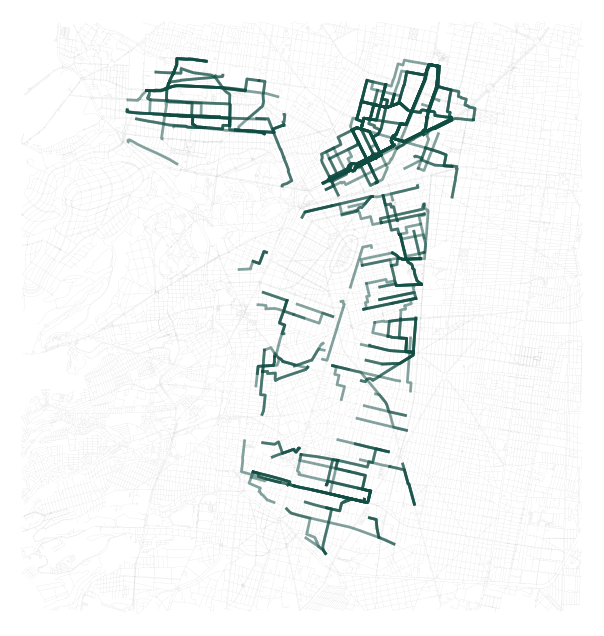

In [4]:
# Gráficamos las rutas más cortas 
plt.rc('figure', figsize=(70,60))
plt.rcParams.update({'figure.figsize': (70,60)})
fig, ax = ox.plot_graph_routes(G_osm, 
                               rutas ,
                               node_size=0,
                               edge_color='#898d8d',
                               orig_dest_size=0, 
                               route_colors='#0f4c42', 
                               route_linewidths=2,
                               edge_linewidth=0.1,
                               edge_alpha=0.2,
                               bgcolor='w',
                               show=False,
                               close=False)

**Nota: Para gráficar los demás años solo se ajusta la ruta de los datos**